In [1]:
# !apt-get update && apt-get install -y graphviz
# !pip install pytz
# !pip install networkx
# !pip install pyyaml
# !pip install graphviz
# !pip install lingam

In [1]:
import time

start = time.time()

In [2]:
import os
import logging
from pytz import timezone
from datetime import datetime
import numpy as np

from data_loader import SyntheticDataset
from models import NoTears
from trainers import ALTrainer
from helpers.config_utils import save_yaml_config, get_train_args
from helpers.log_helper import LogHelper
from helpers.tf_utils import set_seed
from helpers.dir_utils import create_dir
from helpers.analyze_utils import count_accuracy, plot_estimated_graph

# For logging of tensorflow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import pandas as pd


# exp_name = 'skab_tempture' # 14.csv Water supply of increased temperature
# exp_name = 'skab_vibration' # 5.csv Sharply behavior of rotor imbalance
# exp_name = 'skab_less_water' # 12.csv Draining water from the tank until cavitation
# exp_name = 'skab_leaks_fluid' # 1.csv Simulation of fluid leaks and fluid additions
exp_name = 'skab_rotor_imbalance' # 6.csv Linear behavior of rotor imbalance



dataset_path = '../../experiment/datasets/{}.csv'.format(exp_name)
# true_path = '../../experiment/datasets/{}_W_true.csv'.format(exp_name)

headers = pd.read_csv(dataset_path, nrows=0).columns.tolist()

headers = [c for c in headers if c != 'datetime']

df = pd.read_csv(dataset_path, usecols=headers)

# df = df[:300]
X = df.to_numpy()

# headers = []
# for i in range(X.shape[1]):
#     headers.append('x{}'.format(i))

df

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,0.214070,0.264445,2.71937,0.054711,88.8755,29.5102,223.078,128.000,0.0,0.0
1,0.212566,0.263593,2.41487,-0.273216,88.7050,29.5124,226.967,128.000,0.0,0.0
2,0.210063,0.263097,2.09244,0.054711,88.5431,29.5089,217.285,126.646,0.0,0.0
3,0.210345,0.260568,2.67847,0.054711,88.9054,29.5049,233.118,126.680,0.0,0.0
4,0.211236,0.258206,2.33882,0.382638,88.5478,29.5060,214.242,127.680,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1142,0.216234,0.261298,2.33055,0.382638,88.9855,29.7337,207.836,127.320,0.0,0.0
1143,0.213932,0.256775,2.20508,0.382638,88.4070,29.7300,244.342,127.681,0.0,0.0
1144,0.214275,0.257914,2.65496,0.054711,88.3923,29.7300,230.678,127.320,0.0,0.0
1145,0.212897,0.259660,2.69395,0.710565,88.9557,29.7325,225.808,127.681,0.0,0.0


In [5]:
headers = ['震動1', '震動2', '電流', '壓力', '馬達溫度', '水溫', '電壓', '循環水流量', '異常', '異常點變化']
# Accelerometer1 震動1
# Accelerometer2 震動2
# Current 電流
# Pressure 壓力
# Temperature 馬達溫度
# Thermocouple 水溫
# Voltage 電壓
# RateRMS 循環水流量
# anomaly 異常
# changepoint 異常點變化

In [9]:
df.columns = ['震動1', '震動2', '電流', '壓力', '馬達溫度', '水溫', '電壓', '循環水流量', '異常', '異常點變化']
df

,震動1,震動2,電流,壓力,馬達溫度,水溫,電壓,循環水流量,異常,異常點變化
0,0.214070,0.264445,2.71937,0.054711,88.8755,29.5102,223.078,128.000,0.0,0.0
1,0.212566,0.263593,2.41487,-0.273216,88.7050,29.5124,226.967,128.000,0.0,0.0
2,0.210063,0.263097,2.09244,0.054711,88.5431,29.5089,217.285,126.646,0.0,0.0
3,0.210345,0.260568,2.67847,0.054711,88.9054,29.5049,233.118,126.680,0.0,0.0
4,0.211236,0.258206,2.33882,0.382638,88.5478,29.5060,214.242,127.680,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1142,0.216234,0.261298,2.33055,0.382638,88.9855,29.7337,207.836,127.320,0.0,0.0
1143,0.213932,0.256775,2.20508,0.382638,88.4070,29.7300,244.342,127.681,0.0,0.0
1144,0.214275,0.257914,2.65496,0.054711,88.3923,29.7300,230.678,127.320,0.0,0.0
1145,0.212897,0.259660,2.69395,0.710565,88.9557,29.7325,225.808,127.681,0.0,0.0


In [6]:
# w_true = pd.read_csv(true_path, header=None)
# w_true

In [7]:
# Get arguments parsed
args = get_train_args()

args.n = X.shape[0]
args.d = X.shape[1]

In [8]:
# Setup for logging
output_dir = 'output/{}/{}'.format(exp_name, datetime.now(timezone('Asia/Taipei')).strftime('%Y-%m-%d_%H-%M-%S-%f')[:-3])
create_dir(output_dir)
LogHelper.setup(log_path='{}/training.log'.format(output_dir), level_str='INFO')
_logger = logging.getLogger(__name__)

# Save the configuration for logging purpose
save_yaml_config(args, path='{}/config.yaml'.format(output_dir))

# Reproducibility
set_seed(args.seed)

# Get dataset
dataset = SyntheticDataset(args.n, args.d, args.graph_type, args.degree, args.sem_type,
                           args.noise_scale, args.dataset_type)
_logger.info('Finished generating dataset')

2022-04-18 13:16:32,369 INFO - helpers.log_helper - Finished configuring logger.
2022-04-18 13:16:32,389 INFO - __main__ - Finished generating dataset


In [9]:
dataset.X = X
X

array([[  0.21407 ,   0.264445,   2.71937 , ..., 128.      ,   0.      ,
          0.      ],
       [  0.212566,   0.263593,   2.41487 , ..., 128.      ,   0.      ,
          0.      ],
       [  0.210063,   0.263097,   2.09244 , ..., 126.646   ,   0.      ,
          0.      ],
       ...,
       [  0.214275,   0.257914,   2.65496 , ..., 127.32    ,   0.      ,
          0.      ],
       [  0.212897,   0.25966 ,   2.69395 , ..., 127.681   ,   0.      ,
          0.      ],
       [  0.210545,   0.255426,   2.50577 , ..., 127.32    ,   0.      ,
          0.      ]])

In [10]:
# true answer
# dataset.W = w_true.to_numpy()
# w_true

In [11]:
model = NoTears(args.n, args.d, args.seed, args.l1_lambda, args.use_float64)
model.print_summary(print_func=model.logger.info)

trainer = ALTrainer(args.init_rho, args.rho_max, args.h_factor, args.rho_multiply,
                    args.init_iter, args.learning_rate, args.h_tol)
W_est = trainer.train(model, dataset.X, dataset.W, args.graph_thres,
                      args.max_iter, args.iter_step, output_dir)
_logger.info('Finished training model')

2022-04-18 13:16:33,144 INFO - models.notears - Model summary:
2022-04-18 13:16:33,145 INFO - models.notears - ---------
2022-04-18 13:16:33,145 INFO - models.notears - Variables: name (type shape) [size]
2022-04-18 13:16:33,146 INFO - models.notears - ---------
2022-04-18 13:16:33,146 INFO - models.notears - Variable:0 (float32 10x10) [100, bytes: 400]
2022-04-18 13:16:33,146 INFO - models.notears - Total size of variables: 100
2022-04-18 13:16:33,147 INFO - models.notears - Total bytes of variables: 400
2022-04-18 13:16:33,189 INFO - trainers.al_trainer - Started training for 20 iterations
2022-04-18 13:16:33,190 INFO - trainers.al_trainer - rho 1.000E+00, alpha 0.000E+00
2022-04-18 13:16:36,624 INFO - trainers.al_trainer - [Iter 1] loss 1.736E+02, mse 3.982E+05, acyclic 1.821E-01, shd 28, tpr 0.143, fdr 0.857, pred_size 21
2022-04-18 13:16:36,625 INFO - trainers.al_trainer - rho 1.000E+00, alpha 1.821E-01
2022-04-18 13:16:39,374 INFO - trainers.al_trainer - rho 1.000E+01, alpha 1.82

In [12]:
# Save raw estimated graph, ground truth and observational data after training
# np.save('{}/true_graph.npy'.format(output_dir), dataset.W)
np.save('{}/X.npy'.format(output_dir), dataset.X)
np.save('{}/final_raw_estimated_graph.npy'.format(output_dir), W_est)

In [13]:
np.savetxt("{}/W_est.csv".format(output_dir), W_est, delimiter=",")
W_est

array([[ 0.0000000e+00,  1.3910772e-01,  2.6512585e+00,  2.9355113e-03,
         1.7906058e+00,  9.0162792e+00,  4.2548742e+00,  1.2340120e+00,
         5.7929134e-01,  2.2925535e-04],
       [ 3.5369396e-06,  0.0000000e+00,  4.0497956e+00, -1.6700841e-03,
         2.2115793e+00,  8.2848959e+00,  4.2143283e+00,  2.4520841e+00,
         5.2597940e-02, -1.7129509e-03],
       [ 1.2001301e-07,  7.1317627e-05,  0.0000000e+00,  5.8945091e-03,
         1.3464245e+00,  7.9066286e+00,  6.6382904e+00,  8.3765775e-01,
        -8.6800156e-08,  4.1455920e-07],
       [ 1.0499400e-05,  1.5724981e-05,  1.9308395e-04,  0.0000000e+00,
         7.7041101e-01,  2.7403297e+00,  6.4046043e-01,  6.9012767e-01,
        -3.1111463e-06,  2.3377856e-05],
       [-3.4795846e-08, -7.9049514e-09, -1.6586147e-07,  1.3765057e-05,
         0.0000000e+00,  4.2482658e-05,  4.1408163e-01,  1.0499364e+00,
        -1.6957993e-04,  1.8323740e-07],
       [ 3.4284618e-08,  3.4278594e-07, -3.7810745e-04,  8.2051207e-05,
   

2022-04-18 13:22:50,349 WARNING - matplotlib.font_manager - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
2022-04-18 13:22:50,355 WARNING - matplotlib.font_manager - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


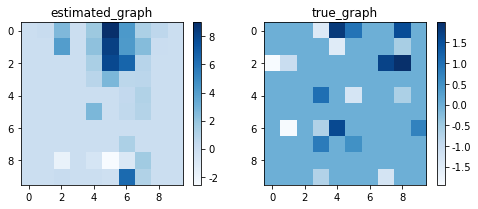

2022-04-18 13:22:50,566 INFO - __main__ - Results: {'fdr': 0.7666666666666667, 'tpr': 1.0, 'fpr': 2.875, 'shd': 45, 'pred_size': 90}


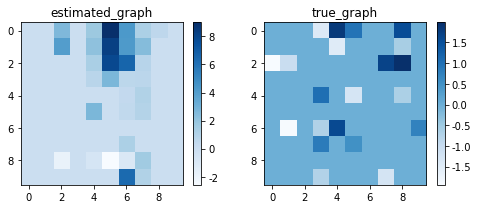

2022-04-18 13:22:50,872 INFO - __main__ - Results after thresholding by 0.3: {'fdr': 0.8125, 'tpr': 0.2857142857142857, 'fpr': 1.0833333333333333, 'shd': 29, 'pred_size': 32}


In [23]:
# Plot raw estimated graph
plot_estimated_graph(W_est, dataset.W, save_name='{}/raw_estimated_graph.png'.format(output_dir))

results = count_accuracy(dataset.W, W_est)
_logger.info('Results: {}'.format(results))

# _logger.info('Thresholding.')
graph_thres = 1
# # Plot thresholded estimated graph

copy_W_est = np.copy(W_est)
copy_W_est[np.abs(copy_W_est) < args.graph_thres] = 0   # Thresholding
plot_estimated_graph(copy_W_est, dataset.W,
                     save_name='{}/thresholded_estimated_graph.png'.format(output_dir))
results_thresholded = count_accuracy(dataset.W, copy_W_est)
_logger.info('Results after thresholding by {}: {}'.format(args.graph_thres, results_thresholded))

In [24]:
end = time.time()

_logger.info('The time used to execute this is given below')
_logger.info(end - start)

2022-04-18 13:22:50,876 INFO - __main__ - The time used to execute this is given below
2022-04-18 13:22:50,876 INFO - __main__ - 380.0897536277771


In [25]:
# c = np.sum(copy_W_est, axis=1)
# c.shape

In [26]:
# copy_W_est

In [27]:
#result_matrix = pd.read_csv("W_true.csv", header=None)

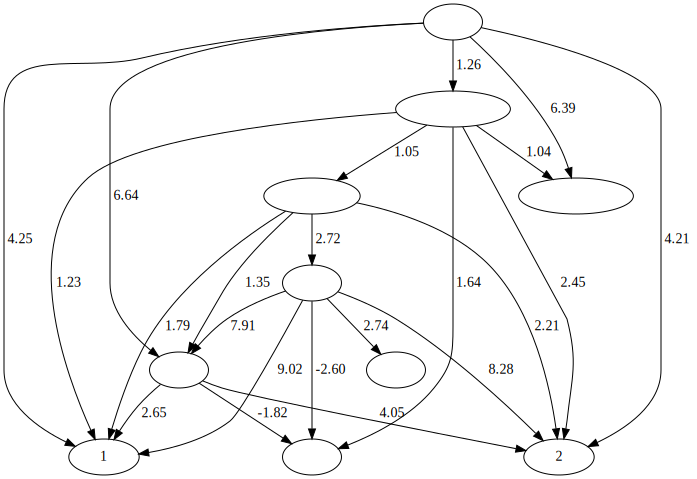

In [28]:
from lingam.utils import make_dot
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] #用來正常顯示中文標簽
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號

dot = make_dot(W_est, labels=headers, lower_limit=graph_thres)

# Save png
dot.format = 'png'
dag_path = dot.render('{}/th_{}_dag'.format(output_dir, graph_thres))

#dot.render('{}/dag'.format(output_dir))
dot
# from IPython.display import Image
# Image(filename=dag_path)

In [20]:
print(dot)

digraph {
	"震動1"
	"震動2"
	"電流"
	"壓力"
	"馬達溫度"
	"水溫"
	"電壓"
	"循環水流量"
	"異常"
	"異常點變化"
	"電流" -> "震動1" [label=2.65]
	"水溫" -> "震動1" [label=9.02]
	"電壓" -> "震動1" [label=4.25]
	"電流" -> "震動2" [label=4.05]
	"馬達溫度" -> "震動2" [label=2.21]
	"水溫" -> "震動2" [label=8.28]
	"電壓" -> "震動2" [label=4.21]
	"循環水流量" -> "震動2" [label=2.45]
	"水溫" -> "電流" [label=7.91]
	"電壓" -> "電流" [label=6.64]
	"水溫" -> "壓力" [label=2.74]
	"馬達溫度" -> "水溫" [label=2.72]
	"水溫" -> "異常" [label=-2.60]
	"電壓" -> "異常點變化" [label=6.39]
	{
		rank=same
	}
}



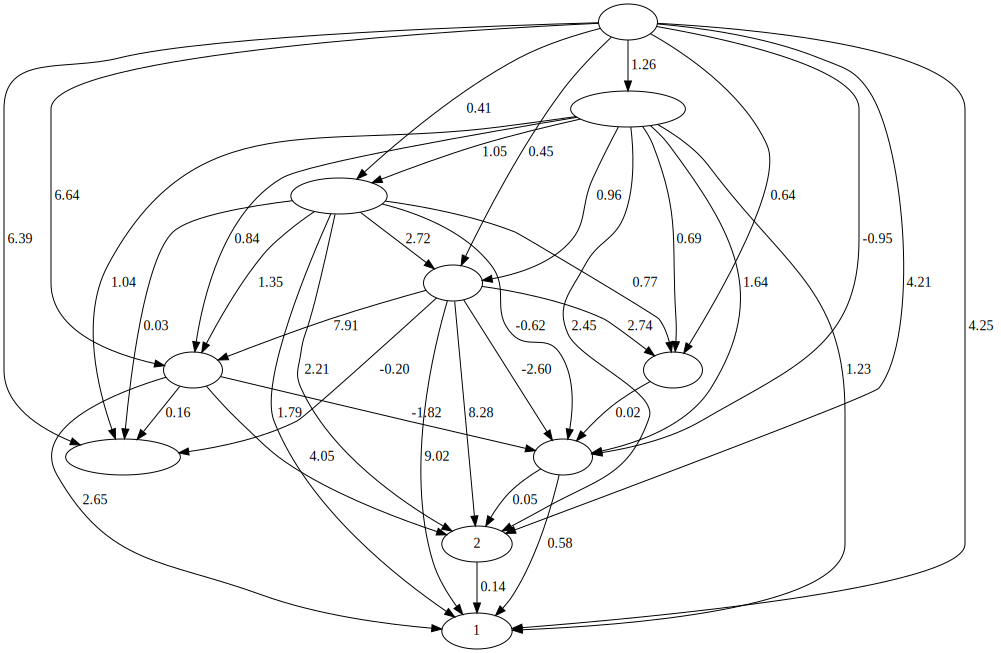

In [21]:
dot = make_dot(W_est, labels=headers)

# # Save png
dot.format = 'png'
dag_path = dot.render('{}/W_est-dag'.format(output_dir))
dot
# #dot.render('{}/dag'.format(output_dir))

# from IPython.display import Image
# Image(filename=dag_path) 

In [22]:
print(dot)

digraph {
	"震動1"
	"震動2"
	"電流"
	"壓力"
	"馬達溫度"
	"水溫"
	"電壓"
	"循環水流量"
	"異常"
	"異常點變化"
	"震動2" -> "震動1" [label=0.14]
	"電流" -> "震動1" [label=2.65]
	"馬達溫度" -> "震動1" [label=1.79]
	"水溫" -> "震動1" [label=9.02]
	"電壓" -> "震動1" [label=4.25]
	"循環水流量" -> "震動1" [label=1.23]
	"異常" -> "震動1" [label=0.58]
	"電流" -> "震動2" [label=4.05]
	"馬達溫度" -> "震動2" [label=2.21]
	"水溫" -> "震動2" [label=8.28]
	"電壓" -> "震動2" [label=4.21]
	"循環水流量" -> "震動2" [label=2.45]
	"異常" -> "震動2" [label=0.05]
	"馬達溫度" -> "電流" [label=1.35]
	"水溫" -> "電流" [label=7.91]
	"電壓" -> "電流" [label=6.64]
	"循環水流量" -> "電流" [label=0.84]
	"馬達溫度" -> "壓力" [label=0.77]
	"水溫" -> "壓力" [label=2.74]
	"電壓" -> "壓力" [label=0.64]
	"循環水流量" -> "壓力" [label=0.69]
	"電壓" -> "馬達溫度" [label=0.41]
	"循環水流量" -> "馬達溫度" [label=1.05]
	"馬達溫度" -> "水溫" [label=2.72]
	"電壓" -> "水溫" [label=0.45]
	"循環水流量" -> "水溫" [label=0.96]
	"電壓" -> "循環水流量" [label=1.26]
	"電流" -> "異常" [label=-1.82]
	"壓力" -> "異常" [label=0.02]
	"馬達溫度" -> "異常" [label=-0.62]
	"水溫" -> "異常" [label=-2.60]
	"電壓" -> "異常" [label=-0.95]
	